# Reddit Post Labels — Bar Plot

This notebook:
1. Pulls reddit posts from InfluxDB (measurement: `reddit_post`)
2. Counts the 3 sentiment labels written to `stance_label`
3. Plots a bar chart of label counts

> If your measurement/field names differ (e.g. comments vs posts), adjust the Flux query cell.


In [73]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt

# If influx_io.py is in the same folder as this notebook, this usually works:
sys.path.insert(0, os.getcwd())

# If it's somewhere else, add that folder too (edit if needed):
# sys.path.insert(0, "/path/to/your/project")

from influx_io import get_client, INFLUX_BUCKET, INFLUX_ORG, load_reddit_posts_with_labels_df, load_reddit_posts_df, load_orf_titles_df


In [74]:
import pandas as pd

# Load labeled reddit posts (non-empty stance_label)
df = load_reddit_posts_with_labels_df(lookback="30d", limit=10000)

df.head(), len(df)


(    result  table               reddit_time      source          usid reddit_id  \
 0  _result      0 2026-01-14 13:51:32+00:00      Aktien  news:3417135   1qcnsl2   
 1  _result      1 2025-12-31 06:12:30+00:00  Aktientool  news:3417204   1q05s6m   
 2  _result      2 2026-01-06 12:53:14+00:00  AlgosOneAI  news:3417172   1q5hrzi   
 3  _result      3 2025-12-29 06:26:25+00:00     Austria  news:3417135   1pyevom   
 4  _result      4 2025-12-24 23:40:10+00:00     Austria  news:3417166   1pv0ca4   
 
                                                                                                                                                                                                   selftext  \
 0  Donald Trump macht inzwischen kaum noch einen Hehl daraus, wie er die Welt sieht. Nationale Interessen über Völkerrecht, Macht über Partnerschaft, Druck über Diplomatie. Die wiederholten Aussagen ...   
 1  ![Chart Analyse](https://s3.smartdeer.de/images/genai/mjtm9tctd7zu3dkf5p.png

In [75]:
# Count the 3 labels
counts = df["stance_label"].value_counts().sort_index()
counts


stance_label
negative    38
neutral     68
positive     5
Name: count, dtype: int64

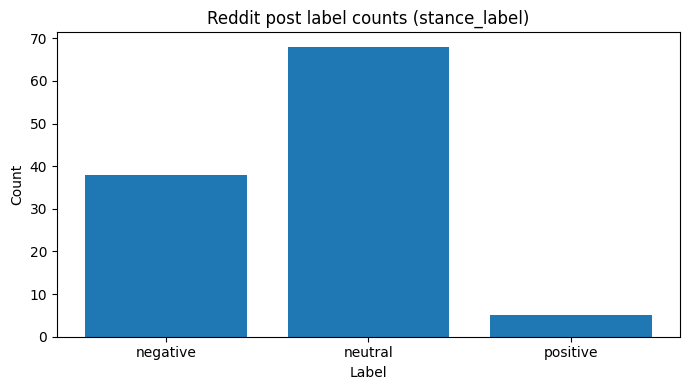

In [76]:
# Bar plot (no explicit colors per best practice)
plt.figure(figsize=(7,4))
plt.bar(counts.index.astype(str), counts.values)
plt.title("Reddit post label counts (stance_label)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


Distribution of Stance Labels in Reddit Posts

The figure shows the distribution of stance labels assigned to Reddit posts. The majority of posts are labeled neutral, followed by a substantial number of negative posts. In contrast, positive posts are comparatively rare.

Specifically, neutral labels dominate the dataset, indicating that most Reddit discussions related to ORF articles express neither clearly positive nor clearly negative sentiment. Negative stances form the second-largest group, suggesting that critical or oppositional reactions are relatively common. Positive stances occur only infrequently, representing a small minority of the labeled data.

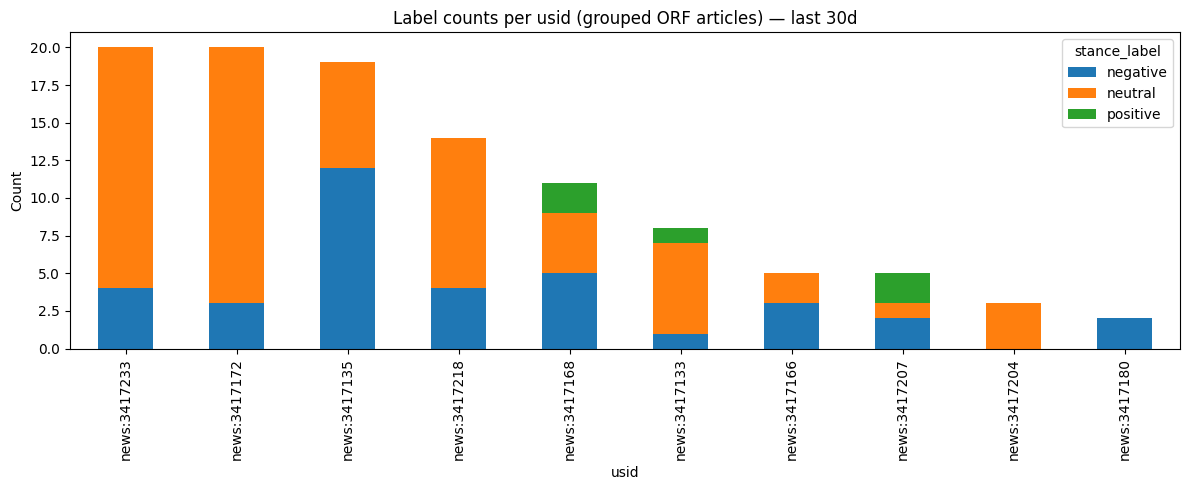

stance_label,negative,neutral,positive
usid,,,
news:3417233,4,16,0
news:3417172,3,17,0
news:3417135,12,7,0
news:3417218,4,10,0
news:3417168,5,4,2
news:3417133,1,6,1
news:3417166,3,2,0
news:3417207,2,1,2
news:3417204,0,3,0


In [77]:
import pandas as pd
import matplotlib.pyplot as plt

LOOKBACK = "30d"   # adjust (e.g. "180d")
LIMIT = 100000     # adjust if needed
TOP_N = 10        # show top N usids (most rows). set None to show all (can get messy)

# --- Load labeled reddit posts from Influx ---
df = load_reddit_posts_with_labels_df(lookback=LOOKBACK, limit=LIMIT)

if df.empty:
    print("No labeled reddit_post rows found.")
else:
    df["stance_label"] = df["stance_label"].astype(str).str.lower()

    # Count labels per usid
    counts = (
        df.groupby(["usid", "stance_label"])
          .size()
          .unstack(fill_value=0)
    )

    # Ensure the 3 expected columns exist (and order them)
    for col in ["negative", "neutral", "positive"]:
        if col not in counts.columns:
            counts[col] = 0
    counts = counts[["negative", "neutral", "positive"]]

    # Choose which usids to plot
    if TOP_N:
        counts["total"] = counts.sum(axis=1)
        counts = counts.sort_values("total", ascending=False).drop(columns=["total"]).head(TOP_N)

    # Plot stacked bars (one bar per usid)
    ax = counts.plot(kind="bar", stacked=True, figsize=(max(10, len(counts)*1.2), 5))
    ax.set_title(f"Label counts per usid (grouped ORF articles) — last {LOOKBACK}")
    ax.set_xlabel("usid")
    ax.set_ylabel("Count")
    plt.tight_layout()
    plt.show()

    display(counts)


Stance Label Distribution per ORF Article (Grouped by usid)

The figure shows the distribution of stance labels (negative, neutral, positive) for Reddit posts grouped by ORF article (usid) over the last 30 days. Each bar represents one ORF article, with stacked segments indicating the number of Reddit posts assigned to each stance.

Several patterns are visible:

Neutral stances dominate across most ORF articles, indicating that Reddit discussions are primarily descriptive or non-polarized with respect to the ORF content.

Negative stances are present for nearly all ORF articles, but their relative proportion varies substantially between articles. Some ORF articles show a strong concentration of negative posts, while others have only a small number.

Positive stances are rare and appear only for a few ORF articles, typically in very small numbers compared to neutral and negative posts.

The total number of Reddit posts per ORF article also varies notably. Some ORF articles attract a large volume of Reddit discussion with mixed stances, while others receive only a handful of posts.

Overall, the plot highlights both topic-dependent engagement and stance heterogeneity: while most ORF articles elicit predominantly neutral reactions, certain topics trigger more polarized or negative responses. This variation supports treating Reddit posts as multiple independent stance expressions toward an ORF article rather than aggregating them into a single label.

The stance classification model (positive / negative / neutral) relies on Reddit posts that are assumed to discuss specific ORF news articles. Since Reddit data is web-scraped and indirectly linked to ORF content, we perform this analysis to evaluate whether the collected Reddit posts actually fit the corresponding ORF articles based on textual similarity.

Only ORF titles are available for matching; therefore, similarity is computed between the ORF title and the Reddit post text (title + selftext). This evaluation focuses on data quality and suitability, not on stance prediction itself

In [79]:
import os
import numpy as np
import pandas as pd

from datetime import datetime, timezone
from influxdb_client import InfluxDBClient
from influx_io import load_orf_titles_df, load_reddit_posts_df


def get_client() -> InfluxDBClient:
    return InfluxDBClient(url=INFLUX_URL, token=INFLUX_TOKEN, org=INFLUX_ORG)


In [80]:
def _try_sentence_transformers():
    try:
        from sentence_transformers import SentenceTransformer
        return SentenceTransformer
    except Exception:
        return None


def compute_similarity(joined: pd.DataFrame, use_embeddings: bool = True) -> pd.DataFrame:
    """
    Adds columns:
      - sim_title_title: ORF title vs reddit title
      - sim_title_full:  ORF title vs (reddit title + selftext)
    """
    if joined.empty:
        return joined

    orf = joined["orf_title"].fillna("").astype(str).tolist()
    rt = joined["reddit_title"].fillna("").astype(str).tolist()
    rf = (joined["reddit_title"].fillna("").astype(str) + "\n" + joined["selftext"].fillna("").astype(str)).tolist()

    SentenceTransformer = _try_sentence_transformers()

    if use_embeddings and SentenceTransformer is not None:
        # --- Embeddings path ---
        from numpy.linalg import norm

        model = SentenceTransformer("all-MiniLM-L6-v2")  # small + fast + decent
        e_orf = model.encode(orf, normalize_embeddings=True)
        e_rt = model.encode(rt, normalize_embeddings=True)
        e_rf = model.encode(rf, normalize_embeddings=True)

        sim_tt = (e_orf * e_rt).sum(axis=1)
        sim_tf = (e_orf * e_rf).sum(axis=1)

        out = joined.copy()
        out["sim_title_title"] = sim_tt.astype(float)
        out["sim_title_full"] = sim_tf.astype(float)
        out["sim_method"] = "embeddings"
        return out

    # --- TF-IDF fallback ---
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.metrics.pairwise import cosine_similarity

    # Fit on combined corpus to share vocabulary
    corpus = orf + rt + rf
    vec = TfidfVectorizer(
        lowercase=True,
        stop_words=None,      # keep None unless you want German stopwords
        ngram_range=(1, 2),
        min_df=2
    )
    X = vec.fit_transform(corpus)

    X_orf = X[0:len(orf)]
    X_rt  = X[len(orf):len(orf)+len(rt)]
    X_rf  = X[len(orf)+len(rt):]

    sim_tt = cosine_similarity(X_orf, X_rt).diagonal()
    sim_tf = cosine_similarity(X_orf, X_rf).diagonal()

    out = joined.copy()
    out["sim_title_title"] = sim_tt.astype(float)
    out["sim_title_full"] = sim_tf.astype(float)
    out["sim_method"] = "tfidf"
    return out


# -------------------------
# Evaluation diagnostics (proxy accuracy)
# -------------------------
def add_orf_rank_and_margin(scored: pd.DataFrame, score_col: str = "sim_title_full") -> pd.DataFrame:
    """
    For each ORF usid:
      - rank reddit matches by score
      - compute margin = top1 - top2
    """
    if scored.empty:
        return scored

    scored = scored.copy()
    scored["rank"] = scored.groupby("usid")[score_col].rank(ascending=False, method="first").astype(int)

    # margin per ORF: top1 - top2
    top = scored[scored["rank"].isin([1, 2])].copy()
    piv = top.pivot_table(index="usid", columns="rank", values=score_col, aggfunc="max")
    # columns: 1,2 maybe missing
    piv["margin_top1_top2"] = (piv.get(1, np.nan) - piv.get(2, np.nan)).astype(float)
    piv = piv[["margin_top1_top2"]].reset_index()

    scored = scored.merge(piv, on="usid", how="left")
    return scored


def random_baseline(scored: pd.DataFrame, n: int = 5000, score_col: str = "sim_title_full", use_embeddings: bool = True) -> pd.DataFrame:
    """
    Builds a random pairing baseline:
      - keeps ORF titles but assigns random reddit texts
      - recomputes similarity for the sample
    Returns df with baseline similarity column `baseline_score`.
    """
    if scored.empty:
        return pd.DataFrame()

    base = scored[["usid", "orf_title", "reddit_title", "selftext"]].copy()
    base = base.sample(n=min(n, len(base)), random_state=42).reset_index(drop=True)

    # shuffle reddit texts
    shuffled = base[["reddit_title", "selftext"]].sample(frac=1.0, random_state=42).reset_index(drop=True)
    base["reddit_title"] = shuffled["reddit_title"]
    base["selftext"] = shuffled["selftext"]

    baseline_scored = compute_similarity(
        base.assign(reddit_id="__baseline__", reddit_time=pd.Timestamp.now(tz="UTC"), source="baseline", stance_label="", stance_conf=0.0),
        use_embeddings=use_embeddings
    )
    baseline_scored = baseline_scored.rename(columns={score_col: "baseline_score"})
    return baseline_scored[["baseline_score", "sim_method"]]


def coverage_vs_threshold(scored: pd.DataFrame, thresholds=None, score_col: str = "sim_title_full") -> pd.DataFrame:
    """
    For each threshold, compute:
      - coverage: % ORF usids with >=1 reddit match above threshold
      - avg_score: mean score among kept matches
      - matches: number of kept matches
    """
    if thresholds is None:
        thresholds = np.round(np.linspace(0.10, 0.70, 13), 2)

    if scored.empty:
        return pd.DataFrame(columns=["threshold", "coverage", "avg_score", "matches"])

    usids_total = scored["usid"].nunique()
    rows = []
    for thr in thresholds:
        kept = scored[scored[score_col] >= thr]
        cov = (kept["usid"].nunique() / usids_total) if usids_total else 0.0
        avg = float(kept[score_col].mean()) if len(kept) else np.nan
        rows.append({"threshold": float(thr), "coverage": float(cov), "avg_score": avg, "matches": int(len(kept))})
    return pd.DataFrame(rows)

In [81]:
def evaluate_orf_reddit_fit(
    lookback_orf: str = "30d",
    lookback_reddit: str = "30d",
    orf_limit: int = 5000,
    reddit_limit: int = 20000,
    use_embeddings: bool = True,
    score_col: str = "sim_title_full",
    topk: int = 5,
):
    # 1) load
    orf_df = load_orf_titles_df(lookback=lookback_orf, limit=orf_limit)
    reddit_df = load_reddit_posts_df(lookback=lookback_reddit, limit=reddit_limit)

    if orf_df.empty:
        raise RuntimeError("No ORF articles found. Check measurement name 'orf_article' and lookback window.")
    if reddit_df.empty:
        raise RuntimeError("No Reddit posts found. Check measurement name 'reddit_post' and lookback window.")

    # 2) join via usid
    joined = reddit_df.merge(orf_df[["usid", "orf_title"]], on="usid", how="inner")

    if joined.empty:
        raise RuntimeError("No join results. Are reddit_post.usid and orf_article.usid matching?")

    # 3) score similarity
    scored = compute_similarity(joined, use_embeddings=use_embeddings)
    scored = add_orf_rank_and_margin(scored, score_col=score_col)

    # 4) pick top-k per ORF (what you likely store / inspect)
    top_matches = scored[scored["rank"] <= topk].sort_values(["usid", "rank"]).reset_index(drop=True)

    # 5) diagnostics
    cov_df = coverage_vs_threshold(scored, score_col=score_col)
    baseline_df = random_baseline(scored, n=5000, score_col=score_col, use_embeddings=use_embeddings)

    # 6) handy tables
    best = top_matches.sort_values(score_col, ascending=False).head(20)[
        ["usid", "orf_title", "reddit_id", "reddit_title", score_col, "sim_title_title", "margin_top1_top2", "source"]
    ]

    worst = top_matches.sort_values(score_col, ascending=True).head(20)[
        ["usid", "orf_title", "reddit_id", "reddit_title", score_col, "sim_title_title", "margin_top1_top2", "source"]
    ]

    ambiguous_orf = (
        top_matches[top_matches["rank"] == 1]
        .sort_values("margin_top1_top2", ascending=True)
        .head(30)[["usid", "orf_title", score_col, "margin_top1_top2"]]
    )

    return {
        "orf_df": orf_df,
        "reddit_df": reddit_df,
        "joined_scored": scored,
        "top_matches": top_matches,
        "coverage_vs_threshold": cov_df,
        "random_baseline_scores": baseline_df,
        "best_examples": best,
        "worst_examples": worst,
        "most_ambiguous_orf": ambiguous_orf,
    }

In [82]:
results = evaluate_orf_reddit_fit(
    lookback_orf="90d",
    lookback_reddit="90d",
    orf_limit=5000,
    reddit_limit=50000,
    use_embeddings=True,   # set False if you don't have sentence-transformers
    score_col="sim_title_full",
    topk=5,
)

print("Scoring method:", results["joined_scored"]["sim_method"].iloc[0])
print("Joined pairs:", len(results["joined_scored"]))
print("ORF covered (any match):", results["joined_scored"]["usid"].nunique(), "/", results["orf_df"]["usid"].nunique())

display(results["coverage_vs_threshold"].head(10))
display(results["most_ambiguous_orf"])
display(results["best_examples"])
display(results["worst_examples"])

Scoring method: embeddings
Joined pairs: 161
ORF covered (any match): 15 / 17


,threshold,coverage,avg_score,matches
0,0.10,1.000000,0.252520,141
1,0.15,1.000000,0.291805,107
2,0.20,1.000000,0.355440,70
3,0.25,0.866667,0.419632,47
4,0.30,0.666667,0.535310,26
5,0.35,0.466667,0.611998,19
6,0.40,0.466667,0.641074,17
7,0.45,0.400000,0.669878,15
8,0.50,0.333333,0.720064,12
9,0.55,0.333333,0.788247,9


,usid,orf_title,sim_title_full,margin_top1_top2
17,news:3417168,Von der Leyen wieder mit Misstrauensvotum konfrontiert,0.305449,0.006561
57,news:3417249,Wahl in Uganda mit Verzögerungen begonnen,0.238576,0.009680
24,news:3417172,Rechnungshof: Fehlende Kontrolle bei Olivenöl,0.342460,0.010486
29,news:3417179,Notstandsmaßnahmen gegen verzweifelte Lage in Kiew,0.286019,0.011178
46,news:3417218,Iran setzt angeblich Hinrichtungen aus,0.273107,0.024514
0,news:3417133,Japan – Südkorea: Spitzenpolitiker mit Jamsession,0.257638,0.043777
31,news:3417180,Fluglinien meiden Luftraum über Iran und Irak,0.327807,0.058891
51,news:3417233,Neue Stromausfälle in Ukraine durch Luftangriffe,0.498871,0.072391
12,news:3417166,USA: Umsetzung von Gaza-Friedensplan in neuer Phase,0.692035,0.072904
41,news:3417207,US-Senat blockiert Beschränkung von Trumps Militärbefugnissen,1.000000,0.152592


,usid,orf_title,reddit_id,reddit_title,sim_title_full,sim_title_title,margin_top1_top2,source
10,news:3417160,USA setzen Visavergabe für 75 Länder aus,1qcugno,USA setzen Visavergabe für 75 Länder aus,1.000000,1.000000,0.547212,USA_de
41,news:3417207,US-Senat blockiert Beschränkung von Trumps Militärbefugnissen,1qdffbr,US-Senat blockiert Beschränkung von Trumps Militärbefugnissen,1.000000,1.000000,0.152592,USA_de
5,news:3417135,Weiter Differenzen mit USA wegen Grönland,1qcyn8p,Dänemark nach Treffen: Weiter Differenzen mit USA wegen Grönland,0.875022,0.875022,0.258959,USA_de
22,news:3417170,USA läuten Phase zwei von Gaza-Plan ein,1qcuh5k,Technokratenregierung: USA läuten Phase zwei von Gaza-Plan ein,0.874208,0.874208,0.698525,USA_de
42,news:3417207,US-Senat blockiert Beschränkung von Trumps Militärbefugnissen,1qdfg1b,US-Senat blockiert Resolution zu Trumps Militärbefugnissen,0.847408,0.847408,0.152592,USA_de
12,news:3417166,USA: Umsetzung von Gaza-Friedensplan in neuer Phase,1qcuh5k,Technokratenregierung: USA läuten Phase zwei von Gaza-Plan ein,0.692035,0.692035,0.072904,USA_de
13,news:3417166,USA: Umsetzung von Gaza-Friedensplan in neuer Phase,1prgnij,"Was macht Trumps Gaza Friedensplan eigentlich, also der Übergang von Phase 1 zu Phase 2? Gaza steht nicht mehr auf der Tagesordnung weil Netanjahu es sabotiert",0.619132,0.758136,0.072904,Staiy
6,news:3417135,Weiter Differenzen mit USA wegen Grönland,1q5f49t,Trump-Berater: Niemand wird mit USA um Grönland kämpfen,0.616062,0.616062,0.258959,USA_de
7,news:3417135,Weiter Differenzen mit USA wegen Grönland,1q83ejj,Insider: USA bereits in Gesprächen mit Grönland,0.570361,0.570361,0.258959,USA_de
8,news:3417135,Weiter Differenzen mit USA wegen Grönland,1qd5ln4,Wie geht es mit Grönland weiter,0.541634,0.699568,0.258959,KeineDummenFragen


,usid,orf_title,reddit_id,reddit_title,sim_title_full,sim_title_title,margin_top1_top2,source
40,news:3417204,Frontex: Deutlicher Rückgang bei irregulären Grenzübertritten,1oqpshf,Das „Gesicht“ der Mittelklasse ist zerbrochen,0.143052,0.193319,0.217614,automobil
35,news:3417180,Fluglinien meiden Luftraum über Iran und Irak,1q8382w,Unmut über Wiener Gastpatienten-Regelung,0.145157,0.180740,0.058891,Austria
34,news:3417180,Fluglinien meiden Luftraum über Iran und Irak,1oofab4,"Wieso macht Österreich nichts gegen Temu, Shein und Co?",0.164047,0.219743,0.058891,Austria
4,news:3417133,Japan – Südkorea: Spitzenpolitiker mit Jamsession,1okn2u8,"Trump warnt vor 155% China-Zoll, Shutdown erreicht Tag 25; Nvidia stellt Blackwell-Chip vor",0.164283,0.052393,0.043777,Aktientool
39,news:3417204,Frontex: Deutlicher Rückgang bei irregulären Grenzübertritten,1oksreg,Wohneigentum: Die Aufstiegsgesellschaft wohnt zur Miete,0.166150,0.279326,0.217614,PolitikBRD
16,news:3417166,USA: Umsetzung von Gaza-Friedensplan in neuer Phase,1pv0ca4,2025 hat mir gezeigt wieso öffentlich-rechtlicher Journalismus nach wie vor wichtig ist,0.166936,0.222964,0.072904,Austria
33,news:3417180,Fluglinien meiden Luftraum über Iran und Irak,1pfm55w,Weihnachtskekse-Schwarzmarkt,0.166949,0.212338,0.058891,Austria
23,news:3417170,USA läuten Phase zwei von Gaza-Plan ein,1pkbaso,Nationalrat beschloss Mietpreisbremse,0.175682,0.139043,0.698525,wien
50,news:3417218,Iran setzt angeblich Hinrichtungen aus,1pyffow,Vermieter will 200€ Kaution für Reinigung einbehalten (möblierte Einliegerwohnung),0.186043,0.216859,0.024514,wohnen
3,news:3417133,Japan – Südkorea: Spitzenpolitiker mit Jamsession,1pk0092,✈️ US B-52 begleiten japanische Kampfjets nach China-Russland-Übungen: Details inside 👇,0.186939,0.271138,0.043777,TagesFakten


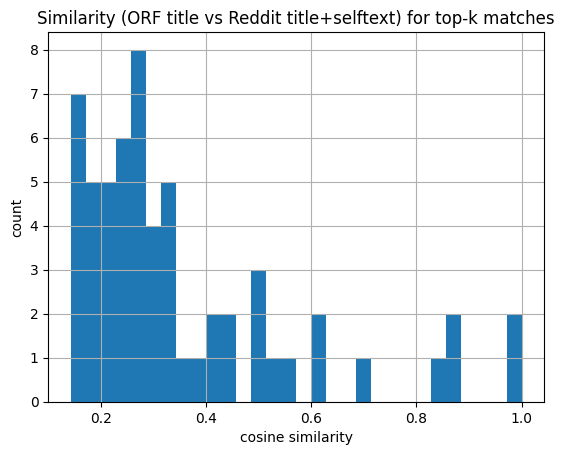

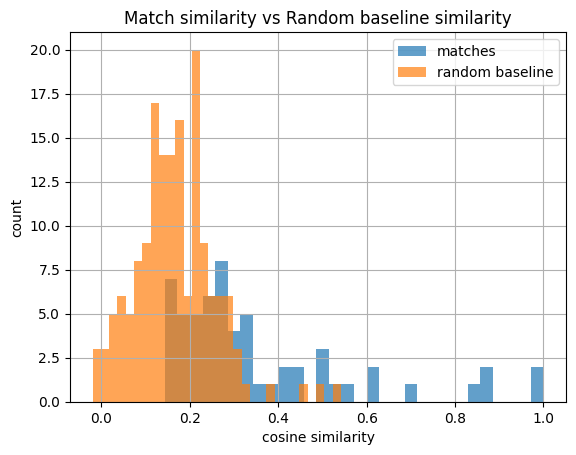

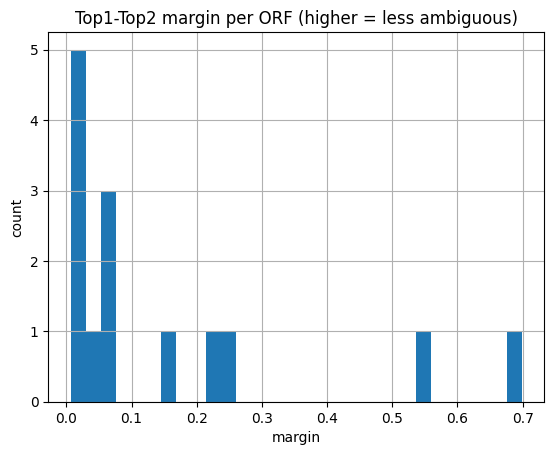

In [83]:
import matplotlib.pyplot as plt

# Histogram of match scores
plt.figure()
results["top_matches"]["sim_title_full"].hist(bins=30)
plt.title("Similarity (ORF title vs Reddit title+selftext) for top-k matches")
plt.xlabel("cosine similarity")
plt.ylabel("count")
plt.show()

# Baseline vs match histogram (if baseline exists)
if not results["random_baseline_scores"].empty:
    plt.figure()
    results["top_matches"]["sim_title_full"].sample(n=min(5000, len(results["top_matches"])), random_state=42).hist(bins=30, alpha=0.7)
    results["random_baseline_scores"]["baseline_score"].hist(bins=30, alpha=0.7)
    plt.title("Match similarity vs Random baseline similarity")
    plt.xlabel("cosine similarity")
    plt.ylabel("count")
    plt.legend(["matches", "random baseline"])
    plt.show()

# Margin distribution (ambiguity)
plt.figure()
m = results["top_matches"][results["top_matches"]["rank"] == 1]["margin_top1_top2"].dropna()
m.hist(bins=30)
plt.title("Top1-Top2 margin per ORF (higher = less ambiguous)")
plt.xlabel("margin")
plt.ylabel("count")
plt.show()

Comparison to a Random Baseline

To verify that the Reddit–ORF associations are meaningful, similarity scores of real ORF–Reddit pairs are compared to a random baseline in which Reddit posts are randomly reassigned to ORF titles.

The results show a clear separation between real matches and random pairs. Randomly assigned Reddit posts concentrate near zero similarity, while the scraped Reddit posts linked to ORF articles exhibit substantially higher similarity scores with a long tail toward strong matches. This demonstrates that the web-scraped Reddit data is not randomly related to ORF content and contains genuine topical alignment.

However, a subset of real matches still overlaps with the random baseline at very low similarity values. These cases likely represent weak or spurious links and should be filtered out before stance labeling.

Ambiguity of Reddit Matches per ORF Article

To assess whether Reddit posts can be uniquely associated with individual ORF articles, we analyze the difference between the highest and second-highest similarity score per ORF article (Top-1–Top-2 margin).

For most ORF articles, this margin is small, indicating that multiple Reddit posts are similarly relevant to the same ORF title. This suggests that Reddit discussions often address the same news topic in parallel, rather than mapping cleanly to a single post–article pair.

A smaller number of ORF articles show large margins, where one Reddit post clearly dominates. These cases represent high-confidence matches and are particularly well-suited for downstream stance labeling.

Implications for Stance Classification

The analysis shows that the scraped Reddit data is generally suitable for stance labeling with respect to ORF articles, but with important caveats:

The Reddit–ORF linkage is meaningful at the topic level, not always at a one-to-one post level.

Low-similarity matches should be excluded to avoid introducing noise into stance labels.

Multiple Reddit posts per ORF article are often valid and should be retained rather than collapsed into a single match.

For stance classification, this implies that Reddit posts should be treated as independent stance expressions toward an ORF topic, rather than as exact textual references to a specific article.